## Note: Python 3.11.x is required

In [1]:
!pip install PyYAML


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
!pip install qiskit-optimization


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [3]:
import os
import yaml
import time
import psutil
import pickle
import itertools
import tracemalloc
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from qiskit_optimization.applications import Tsp

In [4]:
with open("config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

number_of_nodes_classical = config['number_of_nodes_classical']
number_of_nodes_classical

[3, 4, 5, 10, 22]

In [5]:
def generate_tsp(n):
    tsp = Tsp.create_random_instance(n, seed=123)
    adj_matrix = nx.to_numpy_array(tsp.graph)
    # print("distance\n", adj_matrix)

    colors = ["r" for node in tsp.graph.nodes]
    pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
    # draw_graph(tsp.graph, colors, pos)
    return tsp,adj_matrix, colors, pos

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_tsp_solution(distance_matrix, optimal_path=None):
    distance_matrix = np.array(distance_matrix)
    n = len(distance_matrix)
    
    # Create a complete graph
    G = nx.DiGraph()
    
    # Add nodes
    for i in range(n):
        G.add_node(i)
    
    # Add edges with weights
    for i in range(n):
        for j in range(n):
            if i != j:  # Skip self-loops
                G.add_edge(i, j, weight=distance_matrix[i][j])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Position nodes in a circle
    pos = nx.circular_layout(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=800, 
                          node_color='lightblue', 
                          edgecolors='black',
                          ax=ax)
    
    # Set node labels
    city_labels = {i: f"City {i}" for i in range(n)}
    nx.draw_networkx_labels(G, pos, labels=city_labels, font_size=12, font_weight='bold', ax=ax)
    
    # Draw all edges (faded)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.2, ax=ax)
    
    # Get edge weights for labels (only for the optimal path)
    edge_labels = {}
    
    # If optimal path is provided
    if optimal_path:
        # Calculate total distance
        total_distance = 0
        path_edges = []
        edge_weights = []
        
        # Create the path edges and calculate total distance
        for i in range(len(optimal_path) - 1):
            u, v = optimal_path[i], optimal_path[i+1]
            path_edges.append((u, v))
            distance = distance_matrix[u][v]
            total_distance += distance
            edge_weights.append(distance)
            edge_labels[(u, v)] = f"{distance}"
        
        # Draw the optimal path with directional arrows
        nx.draw_networkx_edges(G, pos, 
                              edgelist=path_edges,
                              width=3.0, 
                              edge_color='red',
                              arrows=True,
                              arrowsize=20,
                              arrowstyle='-|>',
                              connectionstyle='arc3,rad=0.1',
                              ax=ax)
        
        # Draw edge labels for the optimal path
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                    font_size=11, font_color='red', 
                                    font_weight='bold', ax=ax)
        
        # Add order indicators along the path (numbers showing the sequence)
        for i, node in enumerate(optimal_path[:-1]):  # Skip the last one as it's a repeat of first
            x, y = pos[node]
            plt.annotate(f'Stop {i+1}', xy=(x, y), xytext=(x, y-0.1),
                        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.8),
                        ha='center', fontsize=10)
        
        # Add total distance information
        plt.figtext(0.5, 0.01, f"Total distance: {total_distance} units", 
                   ha="center", fontsize=14, bbox={"facecolor":"lightgreen", "alpha":0.5, "pad":5})
        
        # Add a legend
        red_line = mpatches.Patch(color='red', label=f'Optimal Route (Distance: {total_distance})')
        plt.legend(handles=[red_line], loc='upper right', fontsize=12)
        
        # Set title with route information
        route_str = " → ".join([f"{city_labels[city]}" for city in optimal_path])
        plt.title(f"Optimal TSP Route:\n{route_str}", fontsize=14, pad=20)
    else:
        # If no path is provided, show all weights
        edge_labels = {(i, j): f"{distance_matrix[i][j]}" for i, j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)
        plt.title("TSP Network (No Optimal Route Provided)", fontsize=14)
    
    plt.axis('off')
    plt.tight_layout()
    
    return fig, ax

In [7]:

def held_karp(distance_matrix):
    
    n = len(distance_matrix)
    C = {}

    # Initialize the distances for subsets of size 1
    for k in range(1, n):
        C[(1 << k, k)] = (distance_matrix[0][k], 0)

    # Iterate through subsets of increasing length
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            bits = 0
            for bit in subset:
                bits |= 1 << bit
            for k in subset:
                prev_bits = bits & ~(1 << k)
                res = []
                for m in subset:
                    if m == k:
                        continue
                    res.append((C[(prev_bits, m)][0] + distance_matrix[m][k], m))
                C[(bits, k)] = min(res)

    # Find the optimal cost and path
    bits = (1 << n) - 2
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + distance_matrix[k][0], k))
    opt, parent = min(res)

    # Backtrack to find the full path
    path = [0]
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits
    path.append(0)

    return opt, path


def run_test_classical(num_vertices, edge_prob=0.5):

    _, adj_matrix, _, _ = generate_tsp(num_vertices)
    # fig1, ax1 = visualize_tsp_network(adj_matrix)
    
    plt.show()
    
    start_time = time.time()
    tracemalloc.start()
    process = psutil.Process()
    mem_before = process.memory_info().rss

    opt, path = held_karp(adj_matrix)
    print("Network Visualization with highlighted optimal path")
    fig2, ax2 = visualize_tsp_solution(adj_matrix, path)
    
    end_time = time.time()
    mem_after = process.memory_info().rss
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    time_taken = end_time - start_time
    memory_used = (mem_after - mem_before) / 10**6  # in MB
    peak_memory_used = peak / 10**6  # in MB

    print(f'time_taken for Nodes {num_vertices} :: {time_taken}')
    return time_taken




Network Visualization with highlighted optimal path
time_taken for Nodes 3 :: 0.14537310600280762


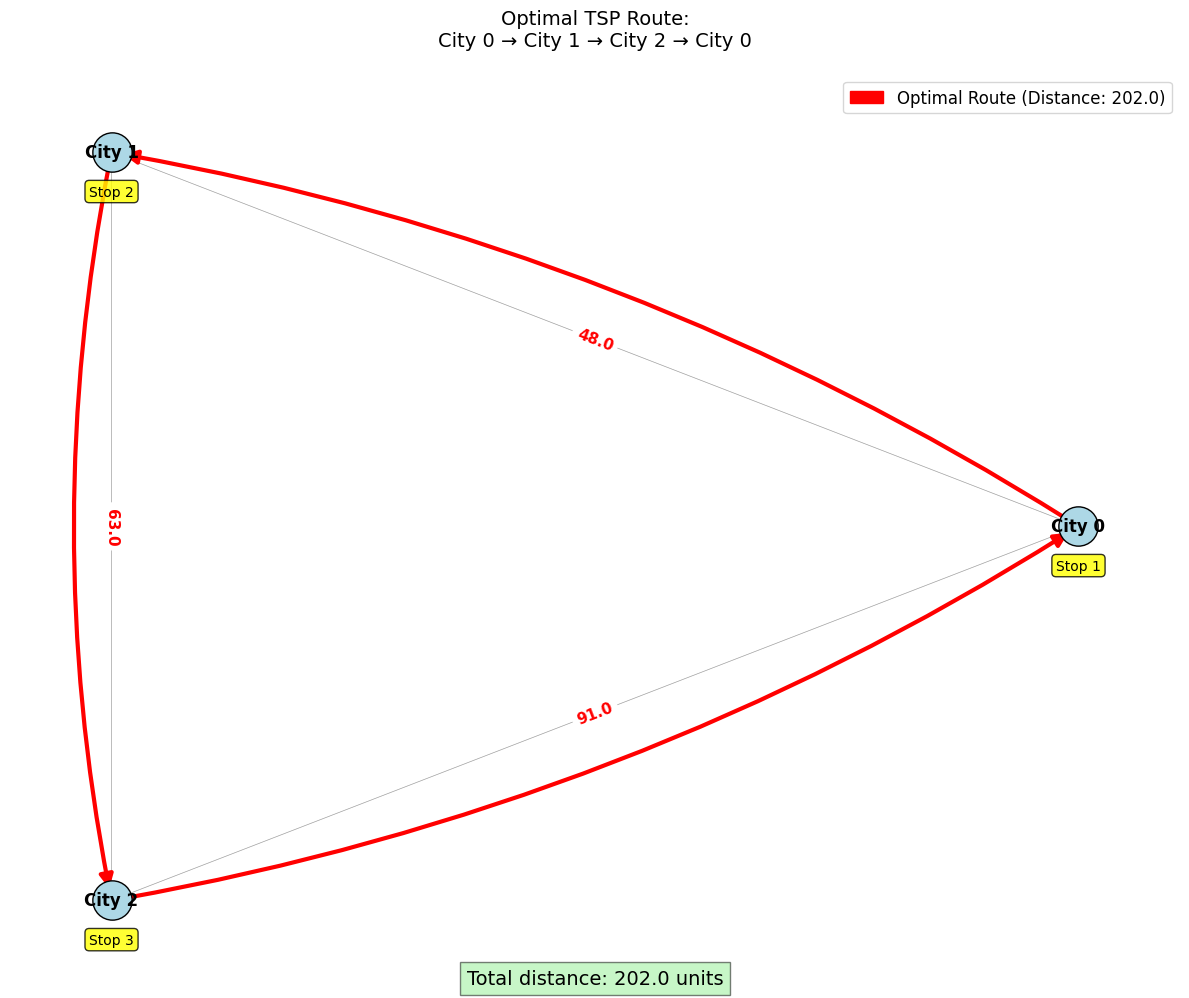

Network Visualization with highlighted optimal path
time_taken for Nodes 4 :: 0.11507797241210938


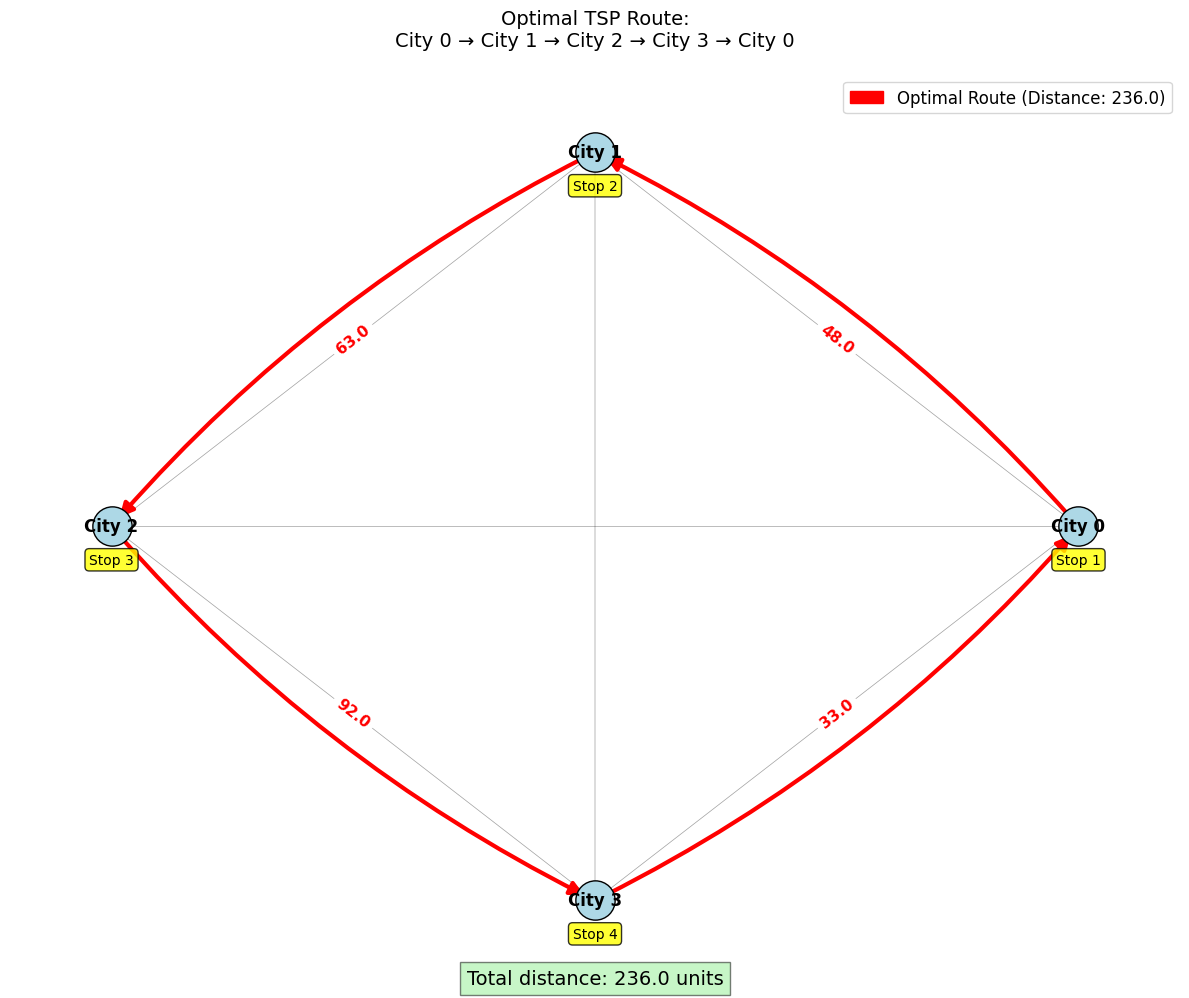

Network Visualization with highlighted optimal path
time_taken for Nodes 5 :: 0.20295214653015137


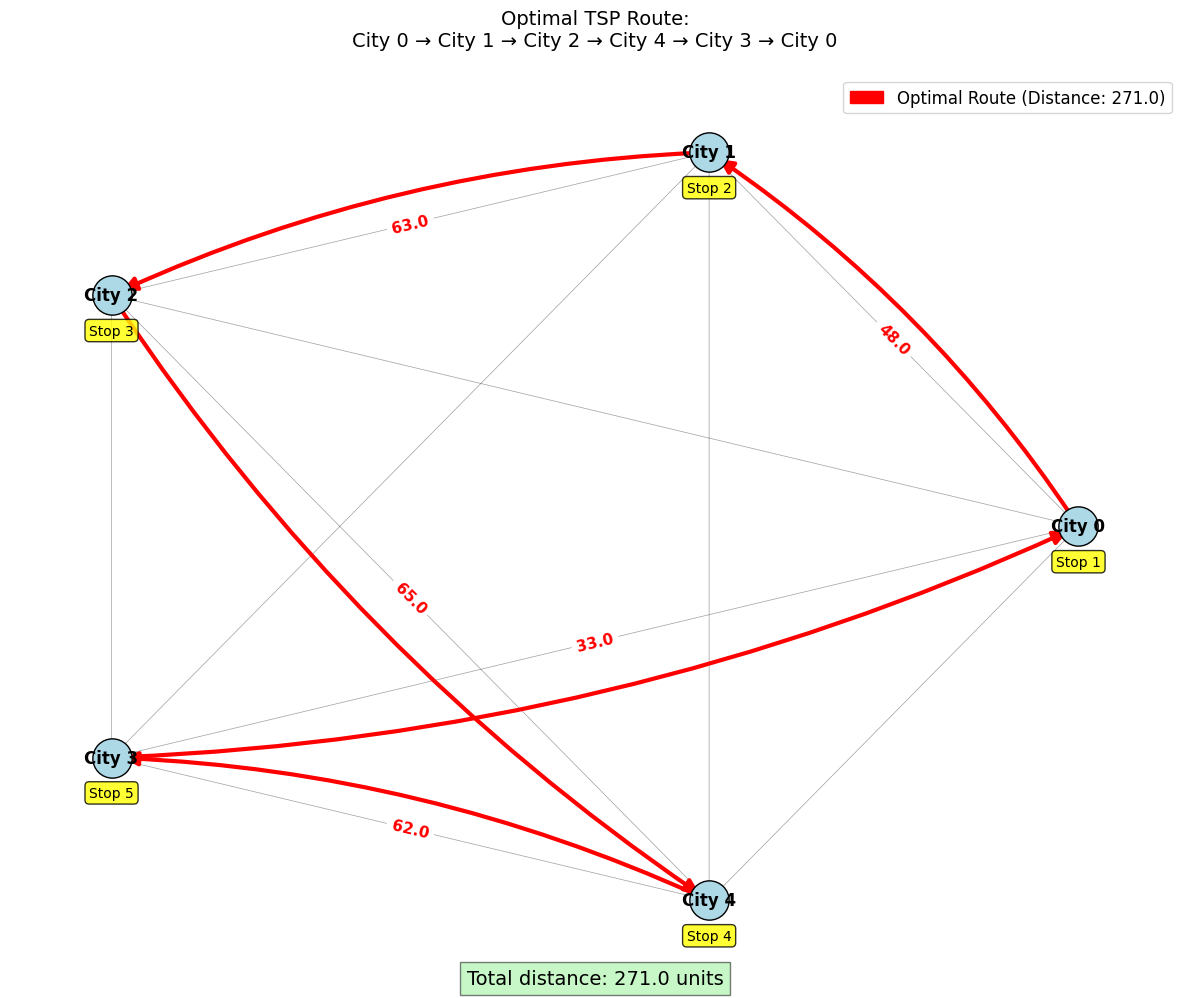

Network Visualization with highlighted optimal path
time_taken for Nodes 10 :: 0.45222020149230957


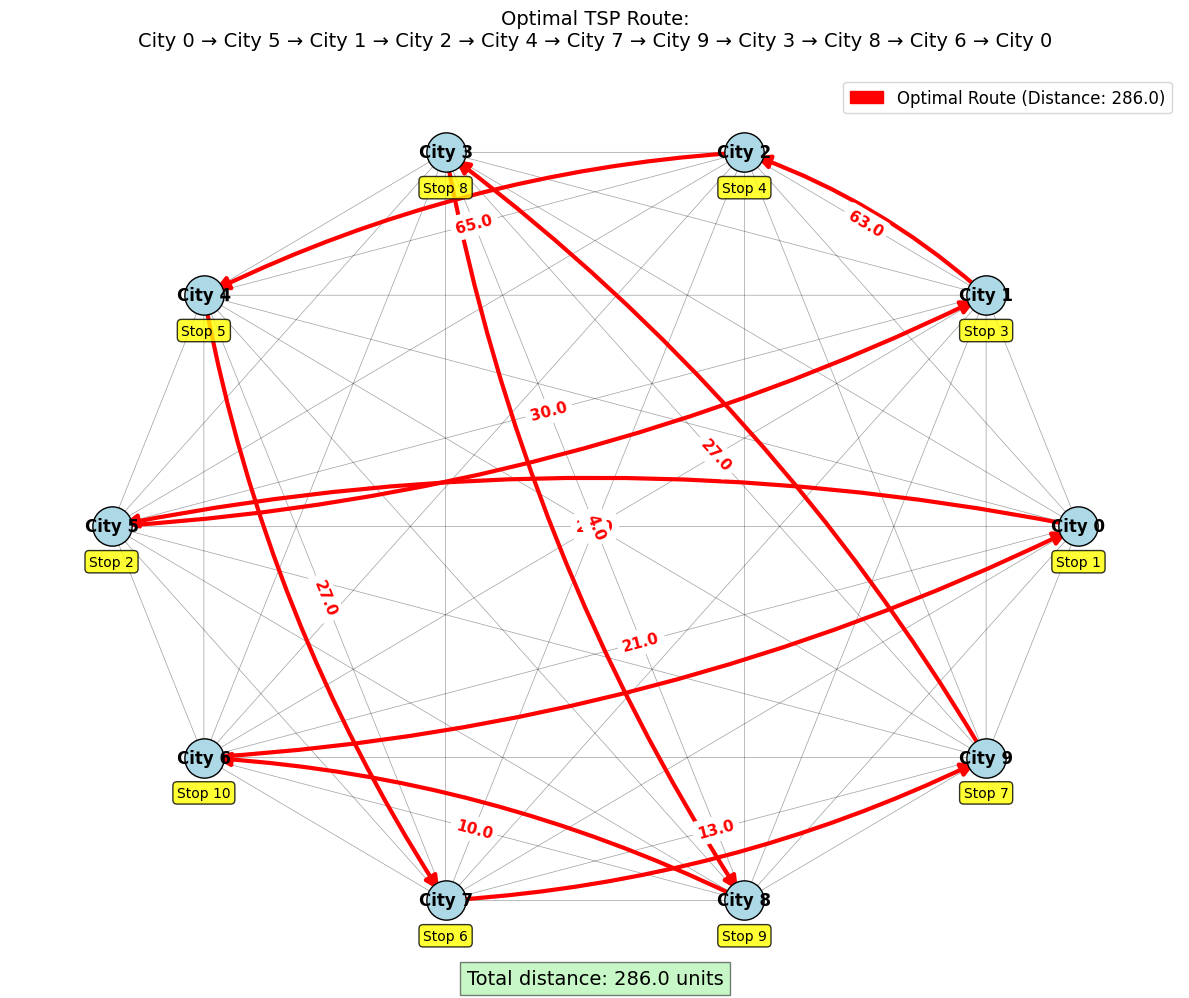

Network Visualization with highlighted optimal path
time_taken for Nodes 22 :: 752.7434687614441
Dictionary has been saved to tsp/cpu_classical_stat.pkl successfully.


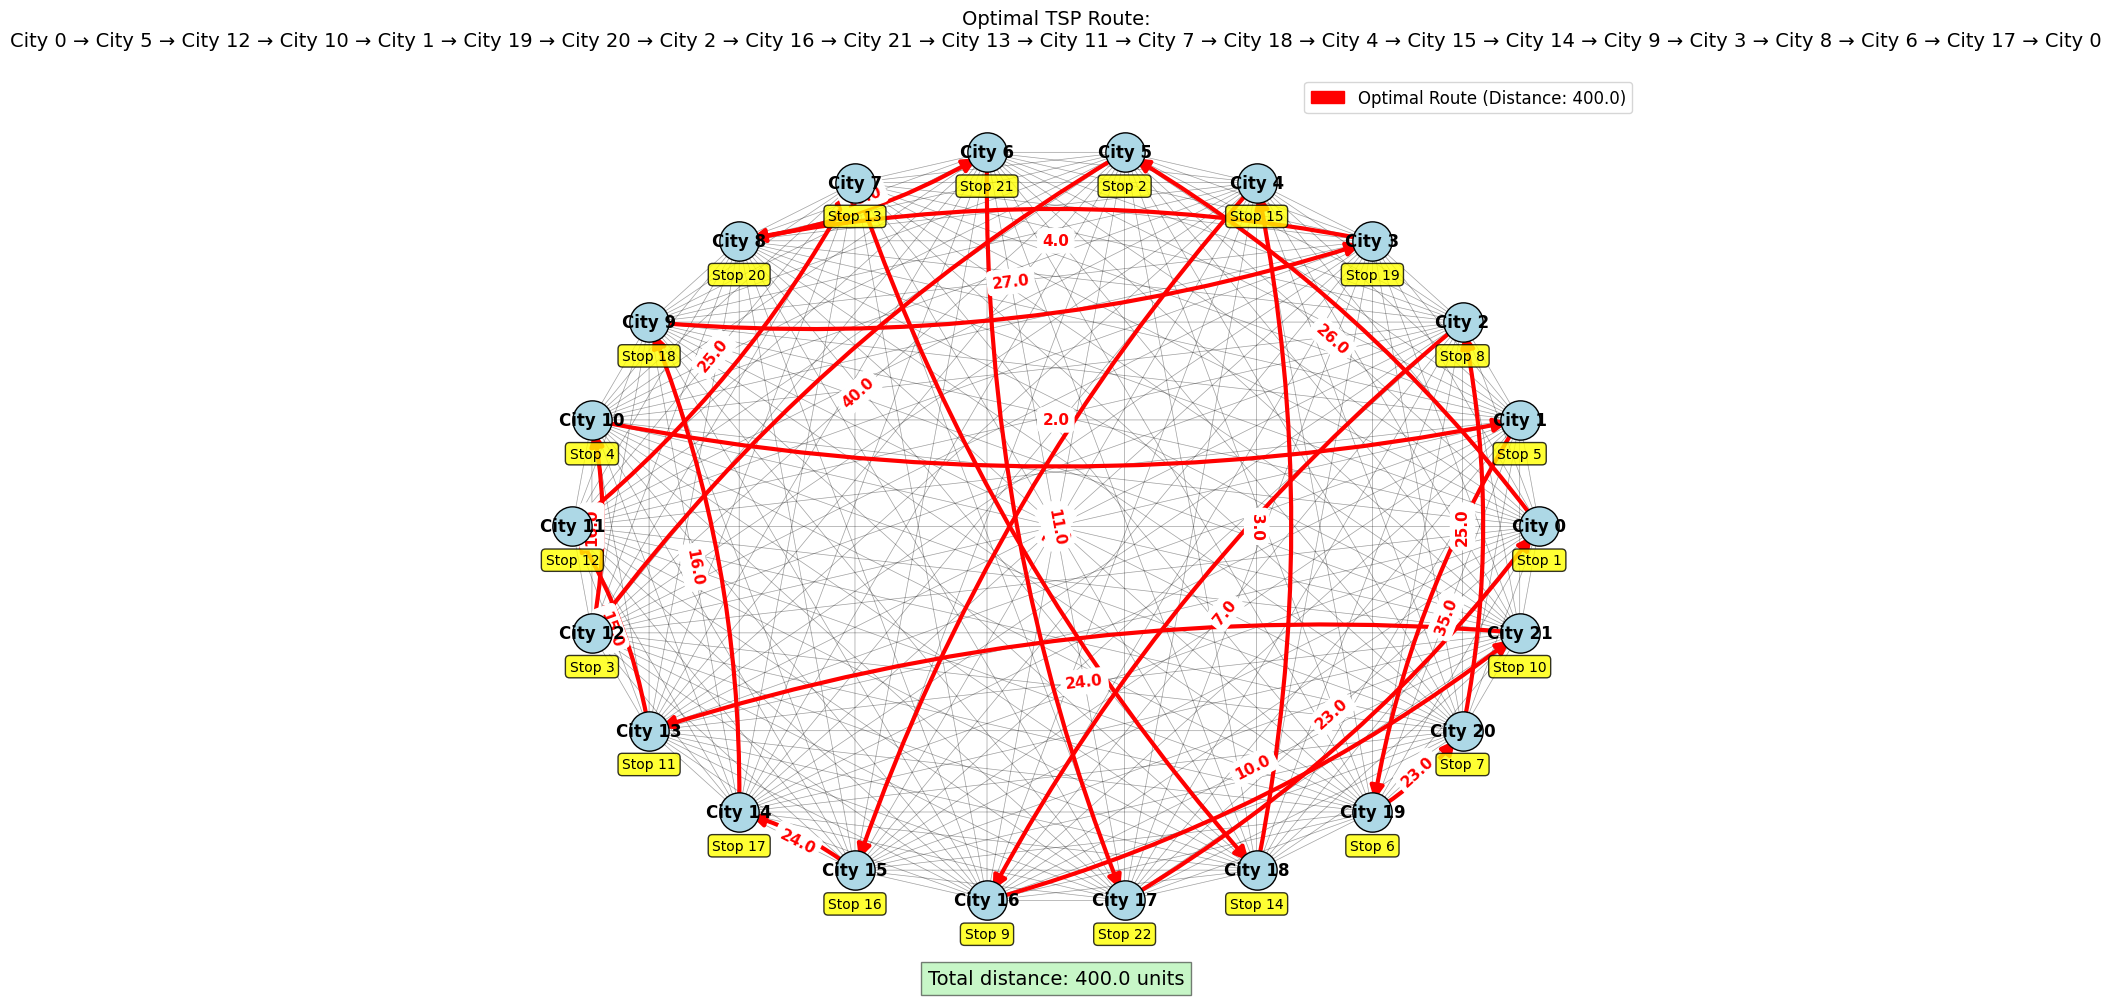

In [8]:
time_classical = []
file_path_classical = 'tsp/cpu_classical_stat.pkl'
force_rerun = True

# Check if the file already exists
if os.path.exists(file_path_classical) and not force_rerun:
    print(f"File {file_path_classical} already exists. It will not be overwritten.")

    with open(file_path_classical, 'rb') as f:
        loaded_dict = pickle.load(f)
        
    time_classical_dict = loaded_dict
else:

    for node in number_of_nodes_classical:
        time_taken = run_test_classical(node)
        time_classical.append(time_taken)
        
    time_classical_dict = {}
    for i, node in enumerate(number_of_nodes_classical):
        time_classical_dict[node] = time_classical[i]

    # Saving the structure
    with open(file_path_classical, 'wb') as f:
        pickle.dump(time_classical_dict, f)
    print(f"Dictionary has been saved to {file_path_classical} successfully.")